In [1]:
from TwitterClient import TwitterClient
from PreProcessor import *
from clustering import KMeans
import matplotlib.pyplot as plt

# Create Dataset

In [2]:
api = TwitterClient()
api.createDataset('ronaldo.txt', '#ronaldo', 20000)

# Read Data

In [3]:
f = open('./Datasets/ronaldo.txt', 'r')
tweets = f.read().split('_$_')
f.close()

In [4]:
tweets

['स्टार फुटबॉलर राबर्ट लेवानडॉस्की ने तोड़ा एक और रिकॉर्ड...देखें पूरी खबर\n#Lewandowski\n#Ronaldo\n#BayernMunich\nhttps://t.co/PcnHqASZH0',
 'स्टार फुटबॉलर राबर्ट लेवानडॉस्की ने तोड़ा एक और रिकॉर्ड...देखें पूरी खबर\n#Lewandowski\n#Ronaldo\n#BayernMunich\nhttps://t.co/xW8t3T0fX5',
 'स्टार फुटबॉलर राबर्ट लेवानडॉस्की ने तोड़ा एक और रिकॉर्ड...देखें पूरी खबर\n#Lewandowski\n#Ronaldo\n#BayernMunich\nhttps://t.co/UuG1IZ9xqg',
 'RT @_iambatman10: Waiting for Sir Alex. @Cristiano. Together again ❤ \nBE LIKE \n#MUFC #Ronaldo #ggmu #siralex https://t.co/ExQU8KcZhK',
 'RT @SatlokChannel: Weekly News Bulletin: \n■ मुजफ्फरपुर मोतियाबिंद कांड में चली गई 15 लोगों की आंखों की रोशनी\n■ ऑमिक्रोन के खतरे के बीच वै…',
 'RT @defcentral: El ‘agente secreto’ que puede acercar el fichaje de Rudiger por el Madrid: Ronaldo Nazario.\n\nhttps://t.co/RuxHwPTkDQ\n\n#Real…',
 'RT @enzomarangio: Sintesi della settimana: caso #Suarez archiviato. La carta di #Ronaldo non si è trovata. Le #plusvalenze non sono un reat…',

# Preprocess

In [5]:
p = PreProcessor(tweets)

In [6]:
processed_tweets = p.preProcess()

In [7]:
len(processed_tweets)

72

In [8]:
c = CreateFreqs(processed_tweets)

In [9]:
freqs = c.createFreqs()

In [10]:
freqs

{'...': 4,
 'lewandowski': 11,
 'ronaldo': 57,
 'bayernmunich': 3,
 'wait': 2,
 'sir': 8,
 'alex': 6,
 '.  .': 1,
 'togeth': 1,
 'like': 2,
 'mufc': 9,
 'ggmu': 2,
 'siralex': 4,
 'weekli': 1,
 'news': 1,
 'bulletin': 1,
 '15': 1,
 'el': 5,
 'agent': 1,
 'secreto': 1,
 'que': 3,
 'pued': 1,
 'acercar': 1,
 'fichaj': 1,
 'de': 3,
 'rudig': 1,
 'por': 1,
 'madrid': 1,
 'nazario': 1,
 'real': 2,
 'sintesi': 1,
 'della': 1,
 'settimana': 1,
 'caso': 1,
 'suarez': 1,
 'archiviato': 1,
 'la': 1,
 'carta': 1,
 'di': 1,
 'non': 3,
 'si': 1,
 'è': 1,
 'trovata': 1,
 'le': 1,
 'plusvalenz': 1,
 'sono': 1,
 'un': 4,
 'reat': 1,
 'cristiano': 13,
 'ferguson': 5,
 'alway': 1,
 'say': 1,
 "he'": 1,
 'father': 1,
 'footbal': 13,
 'narendramodi': 2,
 'garib': 2,
 'pleas': 2,
 'dekho': 1,
 'ko': 1,
 'support': 1,
 'talent': 1,
 'help': 1,
 'today': 1,
 'prove': 1,
 'messi': 16,
 'ballondor': 1,
 'leomessi': 2,
 'penaldo': 1,
 'uefa': 3,
 'nation': 9,
 'leagu': 8,
 'uefanationsleagu': 1,
 'uefa-conmebol

In [11]:
freq_sorted = c.createFreqSorted()
freq_sorted

[('ronaldo', 57),
 ('messi', 16),
 ('cristiano', 13),
 ('footbal', 13),
 ('lewandowski', 11),
 ('deposit', 10),
 ('bonu', 10),
 ('mufc', 9),
 ('nation', 9),
 ('sir', 8),
 ('leagu', 8),
 ('10', 7),
 ('69', 7),
 ('goal', 7),
 ('alex', 6),
 ('en', 6),
 ('bisa', 6),
 ('el', 5),
 ('ferguson', 5),
 ('year', 5),
 ('pulsa', 5),
 ('tanpa', 5),
 ('potongann', 5),
 ('setiap', 5),
 ('harinya', 5),
 ('untuk', 5),
 ('info', 5),
 ('dan', 5),
 ('menarik', 5),
 ('lainnya', 5),
 ('hubungi', 5),
 ('still', 5),
 ('cristianoronaldo', 5),
 ('cr7', 5),
 ('video', 5),
 ('...', 4),
 ('siralex', 4),
 ('un', 4),
 ('south', 4),
 ('american', 4),
 ('equal', 4),
 ('record', 4),
 ('interview', 4),
 ('manutd', 4),
 ('manchest', 4),
 ('team', 4),
 ('app', 4),
 ('creat', 4),
 ('bayernmunich', 3),
 ('que', 3),
 ('de', 3),
 ('non', 3),
 ('uefa', 3),
 ('plan', 3),
 ('fifa', 3),
 ('futbol', 3),
 ('manchesterunit', 3),
 ('realmadrid', 3),
 ('robert', 3),
 ('link', 3),
 ('oldtrafford', 3),
 ('premierleagu', 3),
 ('unit', 3),

In [12]:
vectors = Vectorizer(processed_tweets, freq_sorted).textVectorize()

In [13]:
alphabet = [i[0] for i in freq_sorted]

# Clustering

In [14]:
kmeans = KMeans(4, 100, vectors, alphabet)

In [15]:
clusters = kmeans.run()

In [16]:
clusters

{0: [8],
 1: [22, 23, 24, 25, 26],
 2: [6],
 3: [0,
  1,
  2,
  3,
  4,
  5,
  7,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71]}

In [17]:
print("No of tweets: " + str(len(processed_tweets)))

No of tweets: 72


In [18]:
print("No of features: " + str(len(alphabet)))

No of features: 341


In [19]:
plotData = dict()
for key in clusters.keys():
    plotData[key] = len(clusters[key])

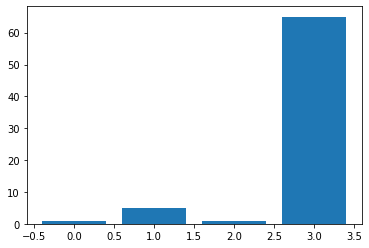

In [20]:
plt.bar(*zip(*plotData.items()))
plt.show()